In [1]:
import contextlib

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.decomposition import PCA
from torch.nn import CosineSimilarity

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
device

device(type='mps')

In [3]:
REPO_DIR = "facebookresearch/dinov3"
PRETRAINED_WEIGHTS_FILE = "dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth"
MODEL="dinov3_vith16plus"

In [4]:
dinov3_vit7b16 = (
    torch.hub.load(
        repo_or_dir=REPO_DIR,
        model=MODEL,
        source="github",
        weights=PRETRAINED_WEIGHTS_FILE,
    )
    .to(device)
    #.eval()
)

Using cache found in /Users/ljoana/.cache/torch/hub/facebookresearch_dinov3_main


In [5]:
dinov3_vit7b16.blocks

ModuleList(
  (0-31): 32 x SelfAttentionBlock(
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (attn): SelfAttention(
      (qkv): LinearKMaskedBias(in_features=1280, out_features=3840, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=1280, out_features=1280, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): LayerScale()
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (mlp): SwiGLUFFN(
      (w1): Linear(in_features=1280, out_features=5120, bias=True)
      (w2): Linear(in_features=1280, out_features=5120, bias=True)
      (w3): Linear(in_features=5120, out_features=1280, bias=True)
    )
    (ls2): LayerScale()
  )
)

In [6]:
def make_transform(resize_size: int = 224):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )

    return transforms.Compose([to_tensor, resize, normalize])


def get_img():
    import requests

    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

    return image

In [7]:
img = get_img()
transform = make_transform(resize_size=1024)

In [8]:
with torch.inference_mode():
    # use_mps_amp = (
    #     device.type == "mps"
    #     and hasattr(torch.amp, "autocast_mode")
    #     and torch.amp.autocast_mode.is_autocast_available("mps")
    # )
    # print(f"Using MPS AMP: {use_mps_amp}")
    # ctx = (
    #     torch.autocast("mps", dtype=torch.bfloat16)
    #     if use_mps_amp
    #     else contextlib.nullcontext()
    # )
    # print(f"Using context: {ctx}")

    # with ctx:
    batch_img = transform(img).unsqueeze(0).to(device)  # instead of [None].cuda()
    tokens = dinov3_vit7b16.get_intermediate_layers(
        x=batch_img, n=dinov3_vit7b16.blocks.__len__(), reshape=True
    )

In [9]:
tokens = tokens[-1]
tokens.shape

torch.Size([1, 1280, 64, 64])

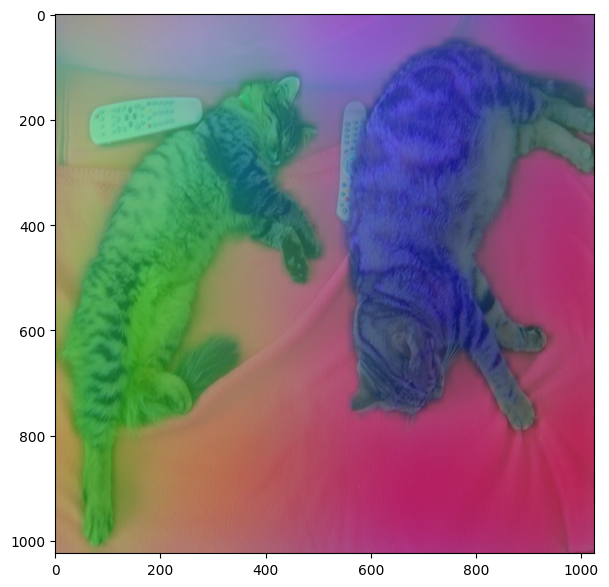

In [10]:
pca = PCA(3, whiten=True)
# Reshape to (HW=4096, C=1270) to compute PCA
feats3d = pca.fit_transform(tokens.view(1280, 4096).permute(1, 0).cpu())
feats3d = feats3d.reshape(1, 64, 64, 3).transpose(0, 3, 1, 2)  # (1, 3, 64, 64)
feats3d_resized = transforms.Resize((1024, 1024), antialias=True)(torch.Tensor(feats3d))
feats3d_resized = (feats3d_resized - feats3d_resized.min()) / (
    feats3d_resized.max() - feats3d_resized.min()
)
batch_img_norm = (batch_img - batch_img.min()) / (batch_img.max() - batch_img.min())

plt.figure(figsize=(7, 7))
plt.imshow(batch_img_norm[0].permute(1, 2, 0).cpu(), alpha=1.0)
plt.imshow(feats3d_resized[0].permute(1, 2, 0).cpu(), alpha=0.75)

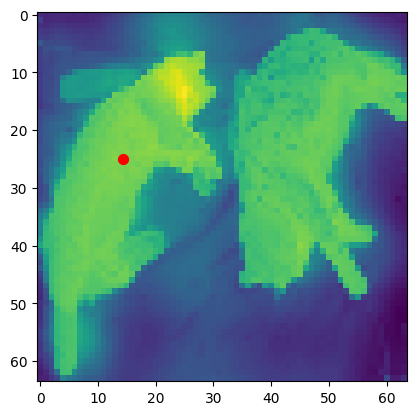

In [11]:
xy = torch.Tensor([230, 400])
patches_selected = xy / torch.Tensor([16., 16.])

cosine_dist = CosineSimilarity(dim=-1)
sim = cosine_dist(tokens[0].permute(1, 2, 0)[int(patches_selected[0]), int(patches_selected[1])][None, None],
         tokens[0].permute(1, 2, 0))
plt.imshow(sim.cpu())
plt.scatter(patches_selected[0], patches_selected[1], s=50, c='red')